### Re-examine feedback, action decoding, weights
- re-run both with dropout layer
- use same set of k-means clusters for electrodes
- re-generate figures for weights

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from models.value_models import ValueNormedModel, ValueNormedDropoutModel
import pickle

from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer
from sklearn.cluster import KMeans

import torch
from torch import nn

import plotly.express as px
import matplotlib.patches as patches

import scipy.stats as sci_stats
import scipy

from itertools import accumulate


matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams.update({'font.size': 20})



species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [5]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Rerun Value Decoding with Dropouts

In [ ]:
num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_values": 12}
# init_params = {"n_inputs": num_neurons, "n_values": 12}

trainer = Trainer(learning_rate=0.05, max_iter=500, batch_size=10000)
wrapped = ModelWrapper(ValueNormedDropoutModel, init_params, trainer, labels)
# wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)
io_utils.save_model_outputs(
    fs, 
    "valued_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

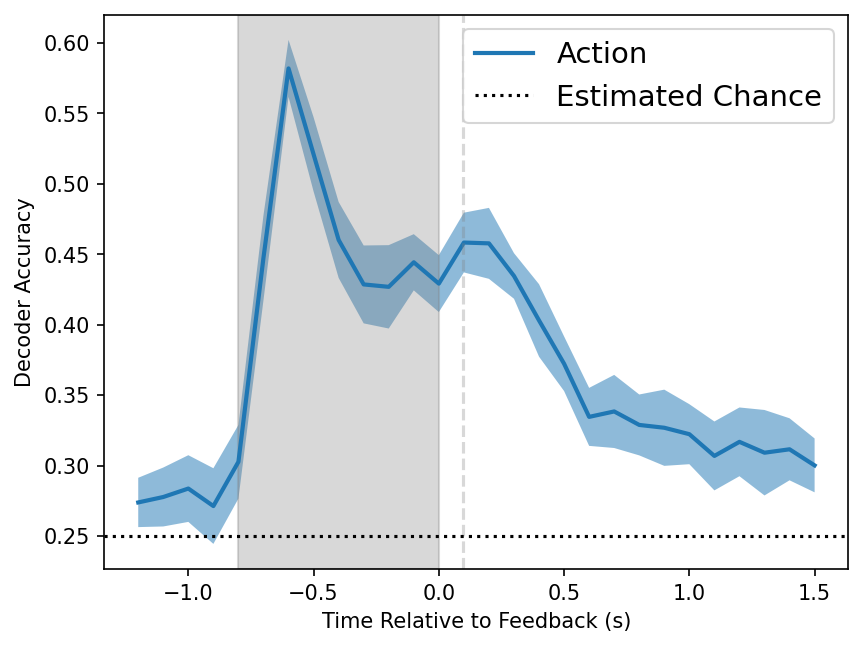

In [93]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "valued_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Action",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Rerun Feedback Decoding with Dropouts

In [ ]:
num_neurons = len(firing_rates.UnitID.unique())
classes = valid_beh.Response.unique()
init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
trainer = Trainer(learning_rate=0.01)
wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

outputs = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
)
io_utils.save_model_outputs(
    fs, 
    "feedback_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
    outputs
)

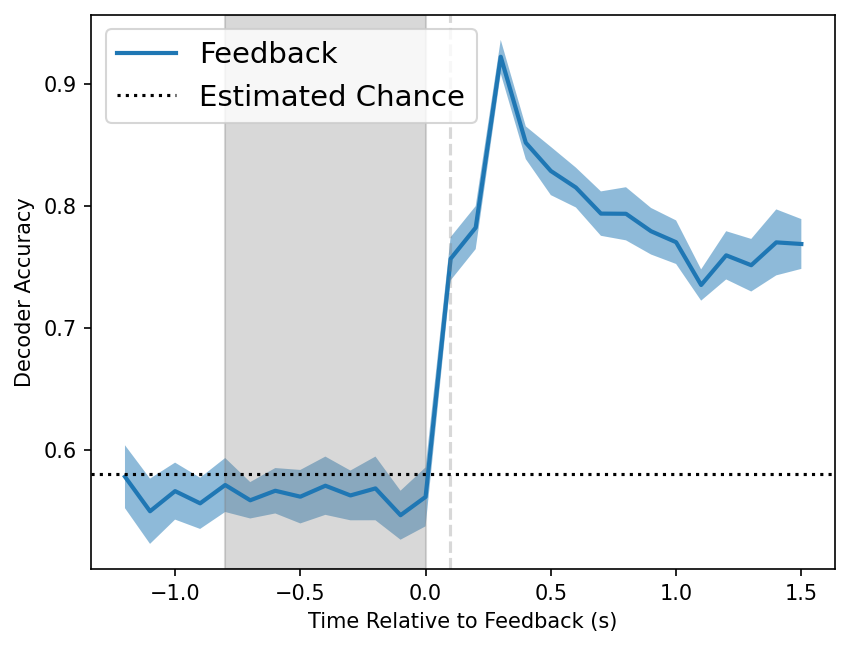

In [94]:
_, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
    fs, 
    "feedback_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1.3, 1.5, 0.1,
    ax,
    label="Feedback",
    right_align=True, 
    # color='black'
)

ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.58, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")
ax.legend(prop={'size': 14})

### Calculate kmeans for unit positions, check and save positions

In [8]:
df = lfp_startup.get_electrode_locations(fs, "nhp", subject, "WCST", str(session), chans_spc="all")
electrode_pos_not_nan = df[~df['x'].isna() & ~df['y'].isna() & ~df['z'].isna()]
np_pos = electrode_pos_not_nan[['x', 'y', 'z']].to_numpy()
spatial_clusters = KMeans(n_clusters=5, random_state=0).fit_predict(np_pos)
electrode_pos_not_nan["spatial_cluster"] = spatial_clusters 

/tmp/ipykernel_149160/2641301624.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrode_pos_not_nan["spatial_cluster"] = spatial_clusters


In [9]:
name_to_color = {
    "anterior hippocampus": '#3366CC', 
    "mpfc" : '#DC3912', 
    "parietal": '#FF9900', 
    "posterior hippocampus": '#109618', 
    "lpfc/fef": '#990099'
}

spatial_cluster_mapping = np.array(["anterior hippocampus", "mpfc", "parietal", "posterior hippocampus", "lpfc/fef"])
electrode_pos_not_nan["SpatialClusterName"] = spatial_cluster_mapping[electrode_pos_not_nan["spatial_cluster"]]

/tmp/ipykernel_149160/2109544662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  electrode_pos_not_nan["SpatialClusterName"] = spatial_cluster_mapping[electrode_pos_not_nan["spatial_cluster"]]


In [10]:
units = spike_general.list_session_units(fs, subject, session)


In [11]:
unit_pos = pd.merge(units, electrode_pos_not_nan, left_on="Channel", right_on="electrode_id", how="left")
unit_pos = unit_pos.astype({"UnitID": int})

In [77]:
unit_pos.to_csv(fs.open(f"l2l.pqz317.scratch/unit_positions.csv", "wb"))

In [ ]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="SpatialClusterName", 
    labels={"SpatialClusterName": "Unit Location"},
    color_discrete_map=name_to_color)
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
camera = dict(
    eye=dict(x=1.3, y=1, z=0.1)
)
temp_grid = dict(
    showgrid=False, 
    zeroline=False, 
    showticklabels=False
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    xaxis=temp_grid,
    yaxis=temp_grid,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    scene_camera=camera
)
fig.show()
fig.write_html("../data/unit_spatial_clusters.html")

### Organize and name spatial regions

In [14]:
unit_pos = pd.read_csv(fs.open(f"l2l.pqz317.scratch/unit_positions.csv", "rb"))
unit_spatial_cluster = unit_pos.spatial_cluster.values

mpfc = np.argwhere(unit_spatial_cluster == 1)
lpfc = np.argwhere(unit_spatial_cluster == 4)
ant_hipp = np.argwhere(unit_spatial_cluster == 0)
post_hipp = np.argwhere(unit_spatial_cluster == 3)
parietal = np.argwhere(unit_spatial_cluster == 2)

reordered_units = np.squeeze(np.concatenate((mpfc, lpfc, parietal, post_hipp, ant_hipp)))

regs = [mpfc, lpfc, parietal, post_hipp, ant_hipp]
lens = [len(reg) for reg in regs]
lens_accum = list(accumulate(lens))
reg_start = lens_accum[:-1].insert(0, 0)
reg_end = list(np.array(lens_accum[1:]) - 1)
lines = np.array(lens_accum[0:-1]) - 0.5

### Re-plot feedback weights

[16.5 29.5 35.5 36.5]
6


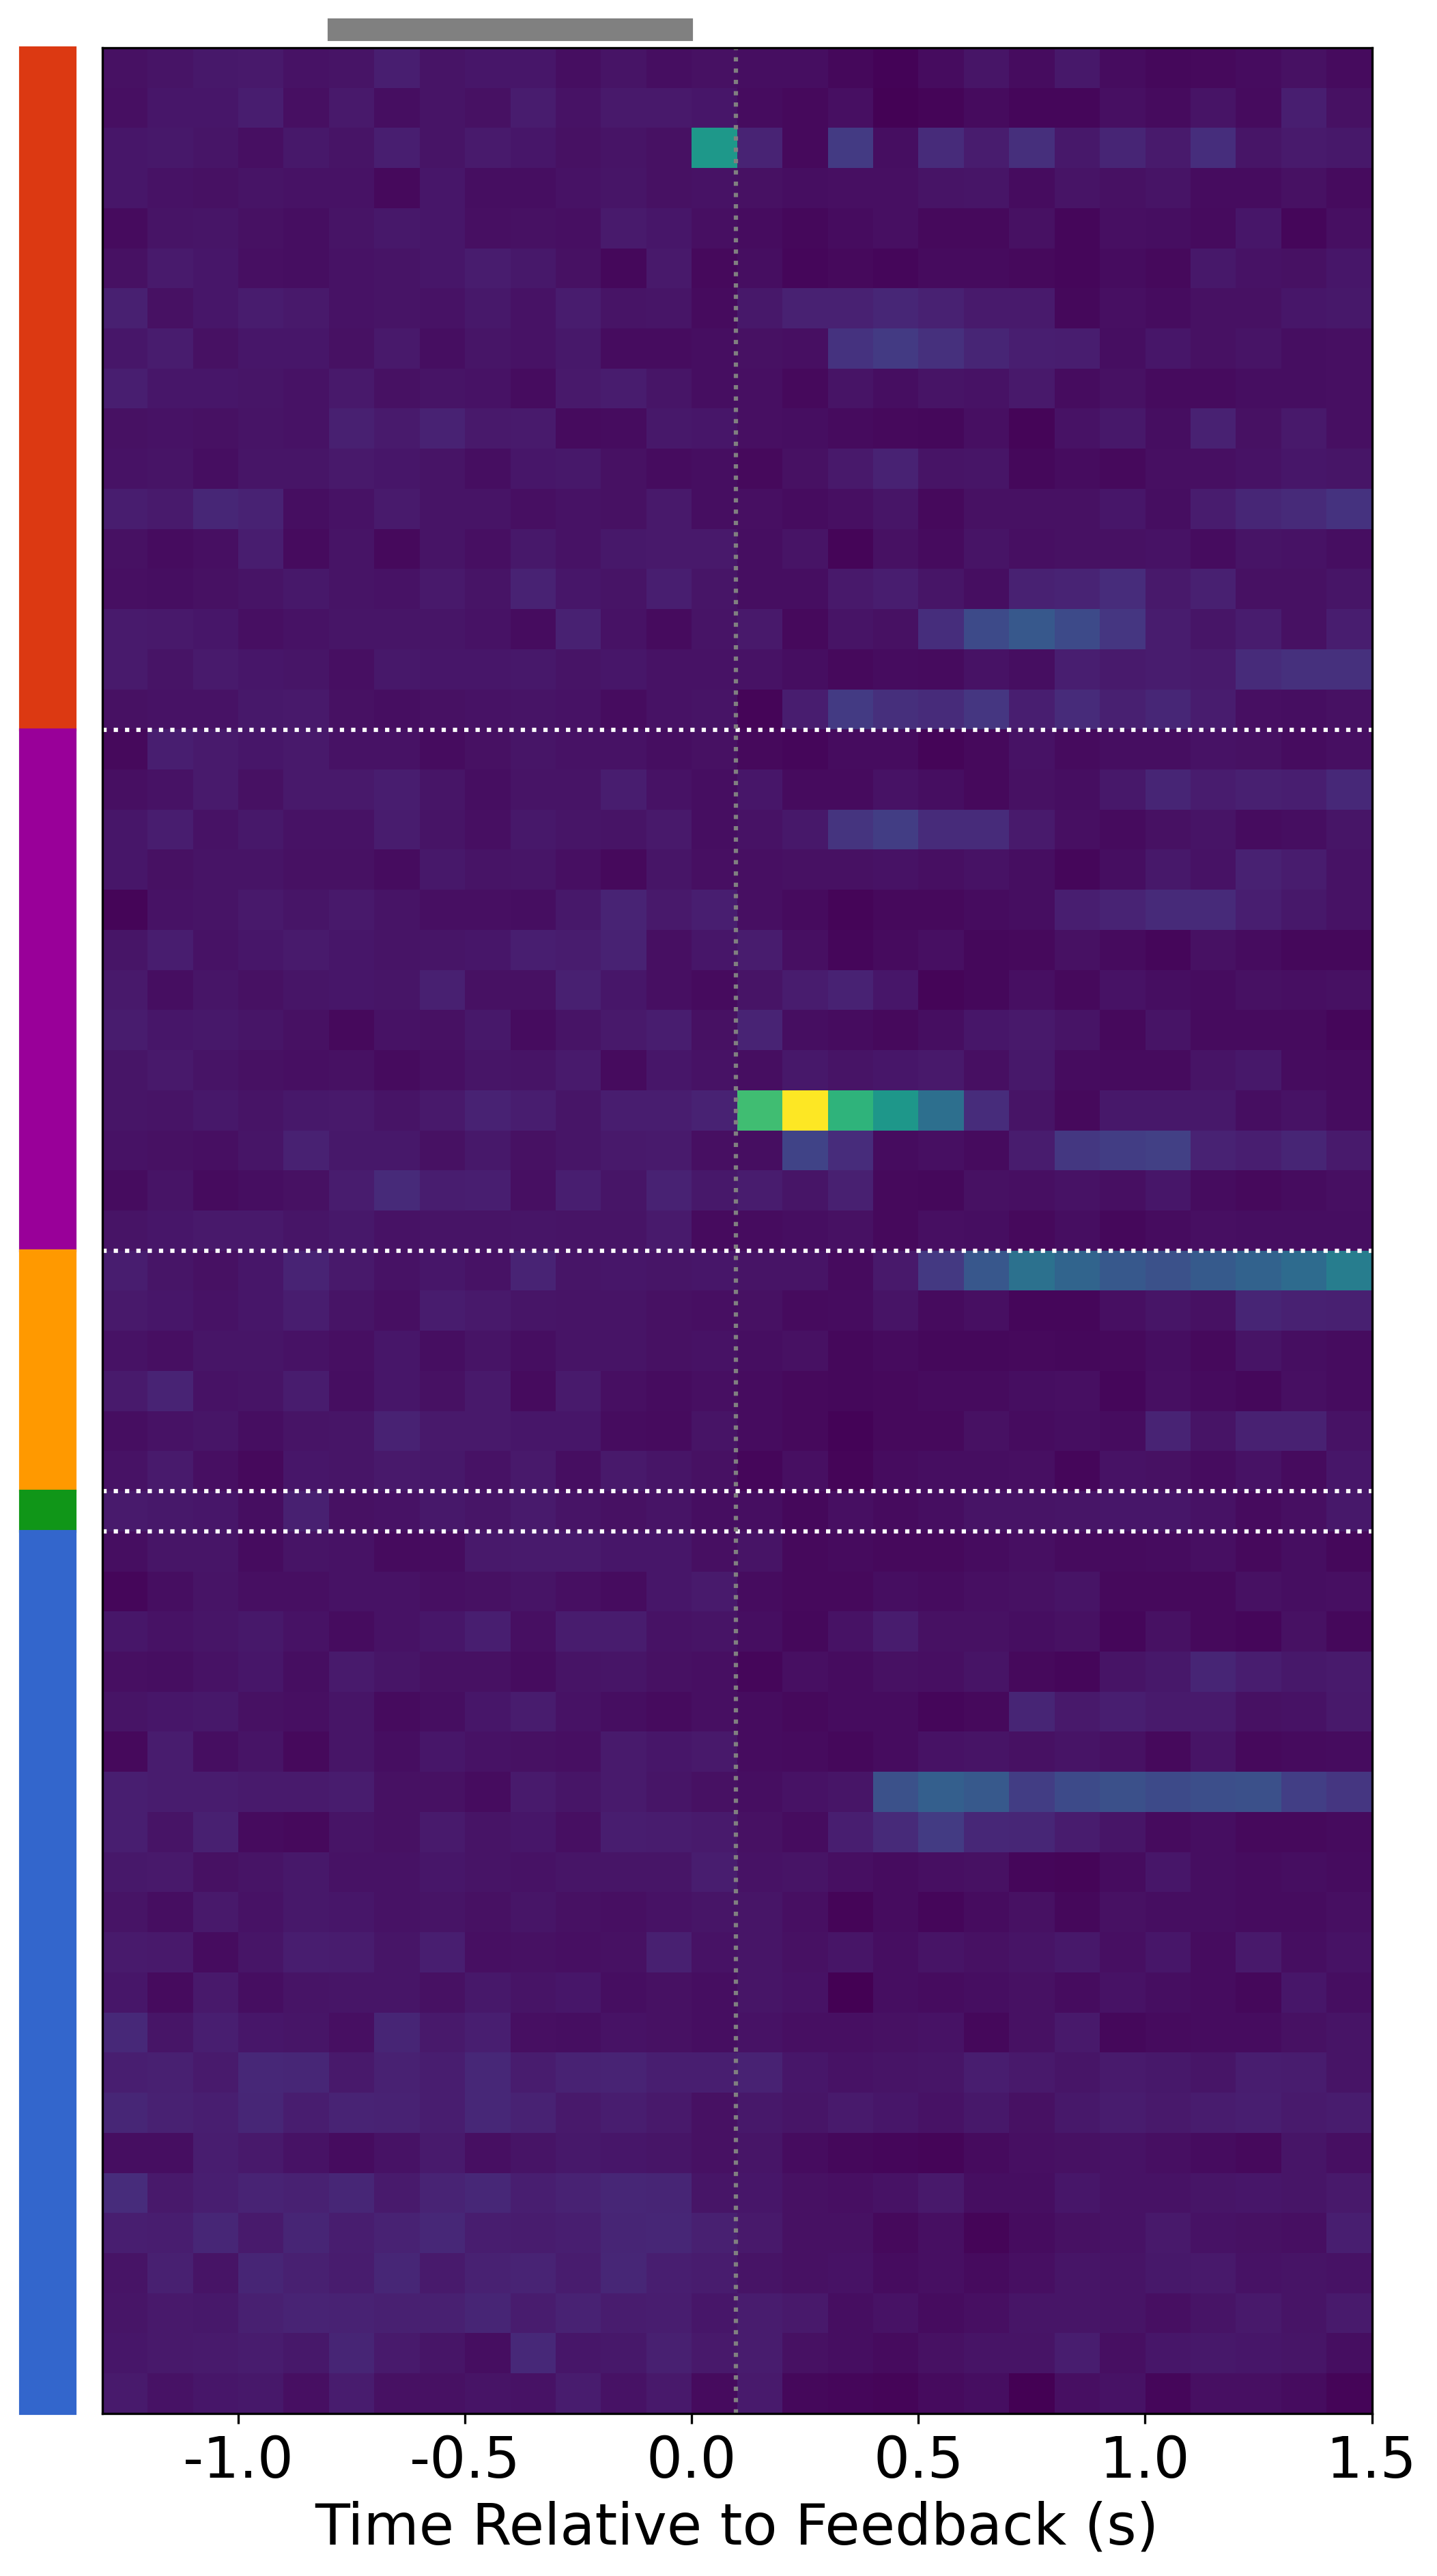

In [20]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
_, _, _, models, _ = io_utils.load_model_outputs(
    fs, 
    "feedback_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 2)
sums = np.sum(weights, axis=0)
normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")
colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]
for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")


In [7]:
pre_interval = 1300
post_interval = 1500
_, _, _, models, _ = io_utils.load_model_outputs(
    fs, 
    "feedback_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 2)
sums = np.sum(weights, axis=0)
normalized = weights / sums
fb_max = normalized[:, 15]
unit_pos["Feedback Weights"] = fb_max

In [8]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="Feedback Weights")
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
camera = dict(
    eye=dict(x=1.3, y=1, z=0.1)
)
temp_grid = dict(
    showgrid=False, 
    zeroline=False, 
    showticklabels=False
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    xaxis=temp_grid,
    yaxis=temp_grid,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    scene_camera=camera
)
fig.write_html("../data/fb_max_weights.html")

### Replot Action weights

[16.5 29.5 35.5 36.5]
6


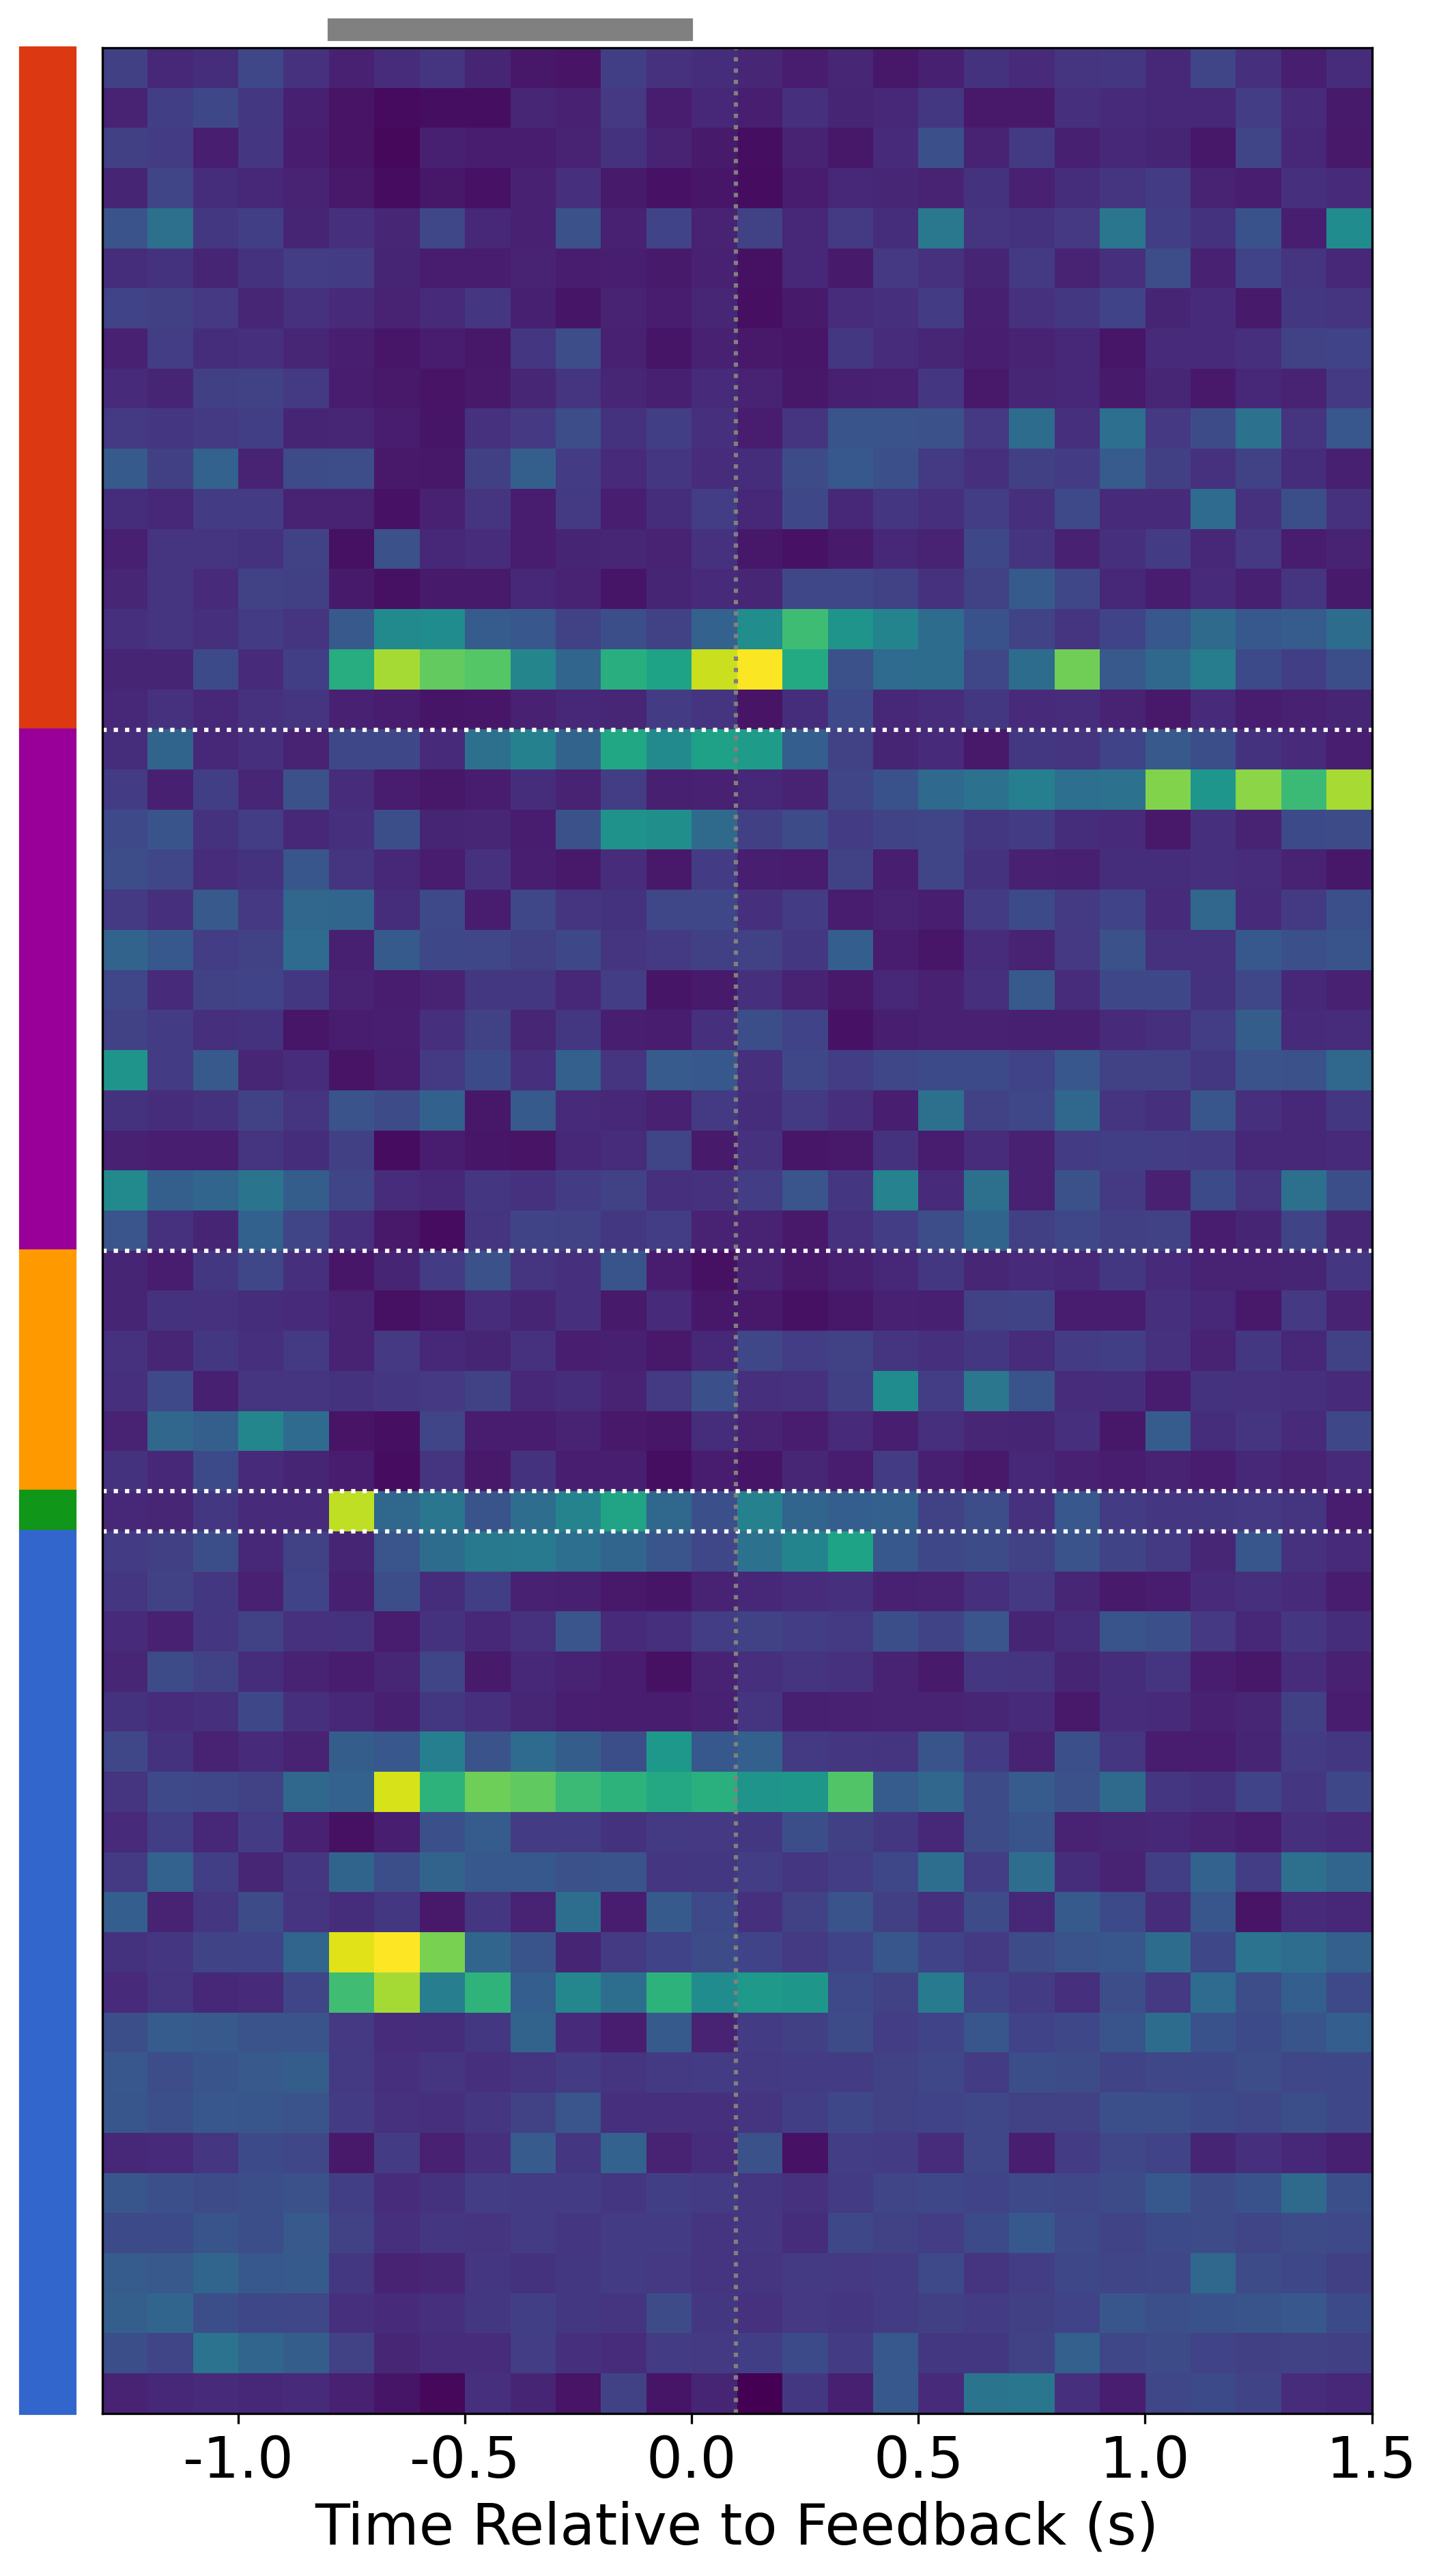

In [21]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
_, _, _, models, _ = io_utils.load_model_outputs(
    fs, 
    "valued_normed_dropout", 
    f"{pre_interval}_fb_{post_interval}",
    "random_split",
)
weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 12)

sums = np.sum(weights, axis=0)

normalized = weights / sums

# reorder by temp then ant
reordered = normalized[reordered_units, :]


fig, ax = plt.subplots(figsize=(8, 15))
colors = ax.matshow(reordered, aspect='auto')
# tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * 10 - 0.5
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.get_yaxis().set_visible(False)
ax.set_ylabel([])
# y_axis = np.arange(0, 59, 5)
# ax.set_yticks(y_axis)
# ax.set_yticklabels(y_axis)

boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
print(lines)
print(len(boundaries))
for line in lines:
    ax.axhline(line, color='white', linestyle="dotted")
colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]
for i in range(len(boundaries)-1):
    rect = patches.Rectangle(
        (
            -1.3 - 1,
            (boundaries[i])#+boundaries[i+1]) / 2
        ),
        1.2,
        (boundaries[i+1]-boundaries[i]),
        edgecolor=colormap[i],
        facecolor=colormap[i],
        clip_on=False
    )
    ax.add_patch(rect)
gray_rect = patches.Rectangle(
    (4.5, -1.2), 8, 0.5,
    edgecolor="gray",
    facecolor="gray",
    clip_on=False,
)
ax.add_patch(gray_rect)
ax.axvline(13.48, color="gray", linestyle="dotted")


In [101]:
action_max = normalized[:, 4]
unit_pos["Action Weights"] = action_max

In [ ]:
fig1 = px.scatter_3d(
    unit_pos, x="x", y="y", z="z", 
    color="Action Weights")
fig = visualization_utils.plotly_add_glass_brain(fs, fig1, subject, areas='all', show_axis=False)
fig.update_layout(
    autosize=True,
    width=750,
    height=700,
)
camera = dict(
    eye=dict(x=1.3, y=1, z=0.1)
)
temp_grid = dict(
    showgrid=False, 
    zeroline=False, 
    showticklabels=False
)
fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    xaxis=temp_grid,
    yaxis=temp_grid,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    scene_camera=camera
)
fig.show()
fig.write_html("../data/action_max_weights.html")

### Re-calculated Feature Decoding with Normed Dropout LR

In [8]:
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))
feature_selections = feature_selections[feature_selections.TrialNumber.isin(valid_beh.TrialNumber)]

In [ ]:
for feature_dim in feature_dims:
    num_neurons = len(firing_rates.UnitID.unique())
    classes = feature_selections[feature_dim].unique()
    init_params = {"n_inputs": num_neurons, "p_dropout": 0.5, "n_classes": len(classes)}
    trainer = Trainer(learning_rate=0.01)
    wrapped = ModelWrapper(NormedDropoutMultinomialLogisticRegressor, init_params, trainer, classes)

    mode = "SpikeCounts"

    # prep data for classification
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = feature_selections.rename(columns={feature_dim: "Feature"})

    random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

    outputs = classifier_utils.evaluate_classifiers_by_time_bins(
        wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
    )
    io_utils.save_model_outputs(
        fs, 
        f"{feature_dim}_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
        outputs
    )

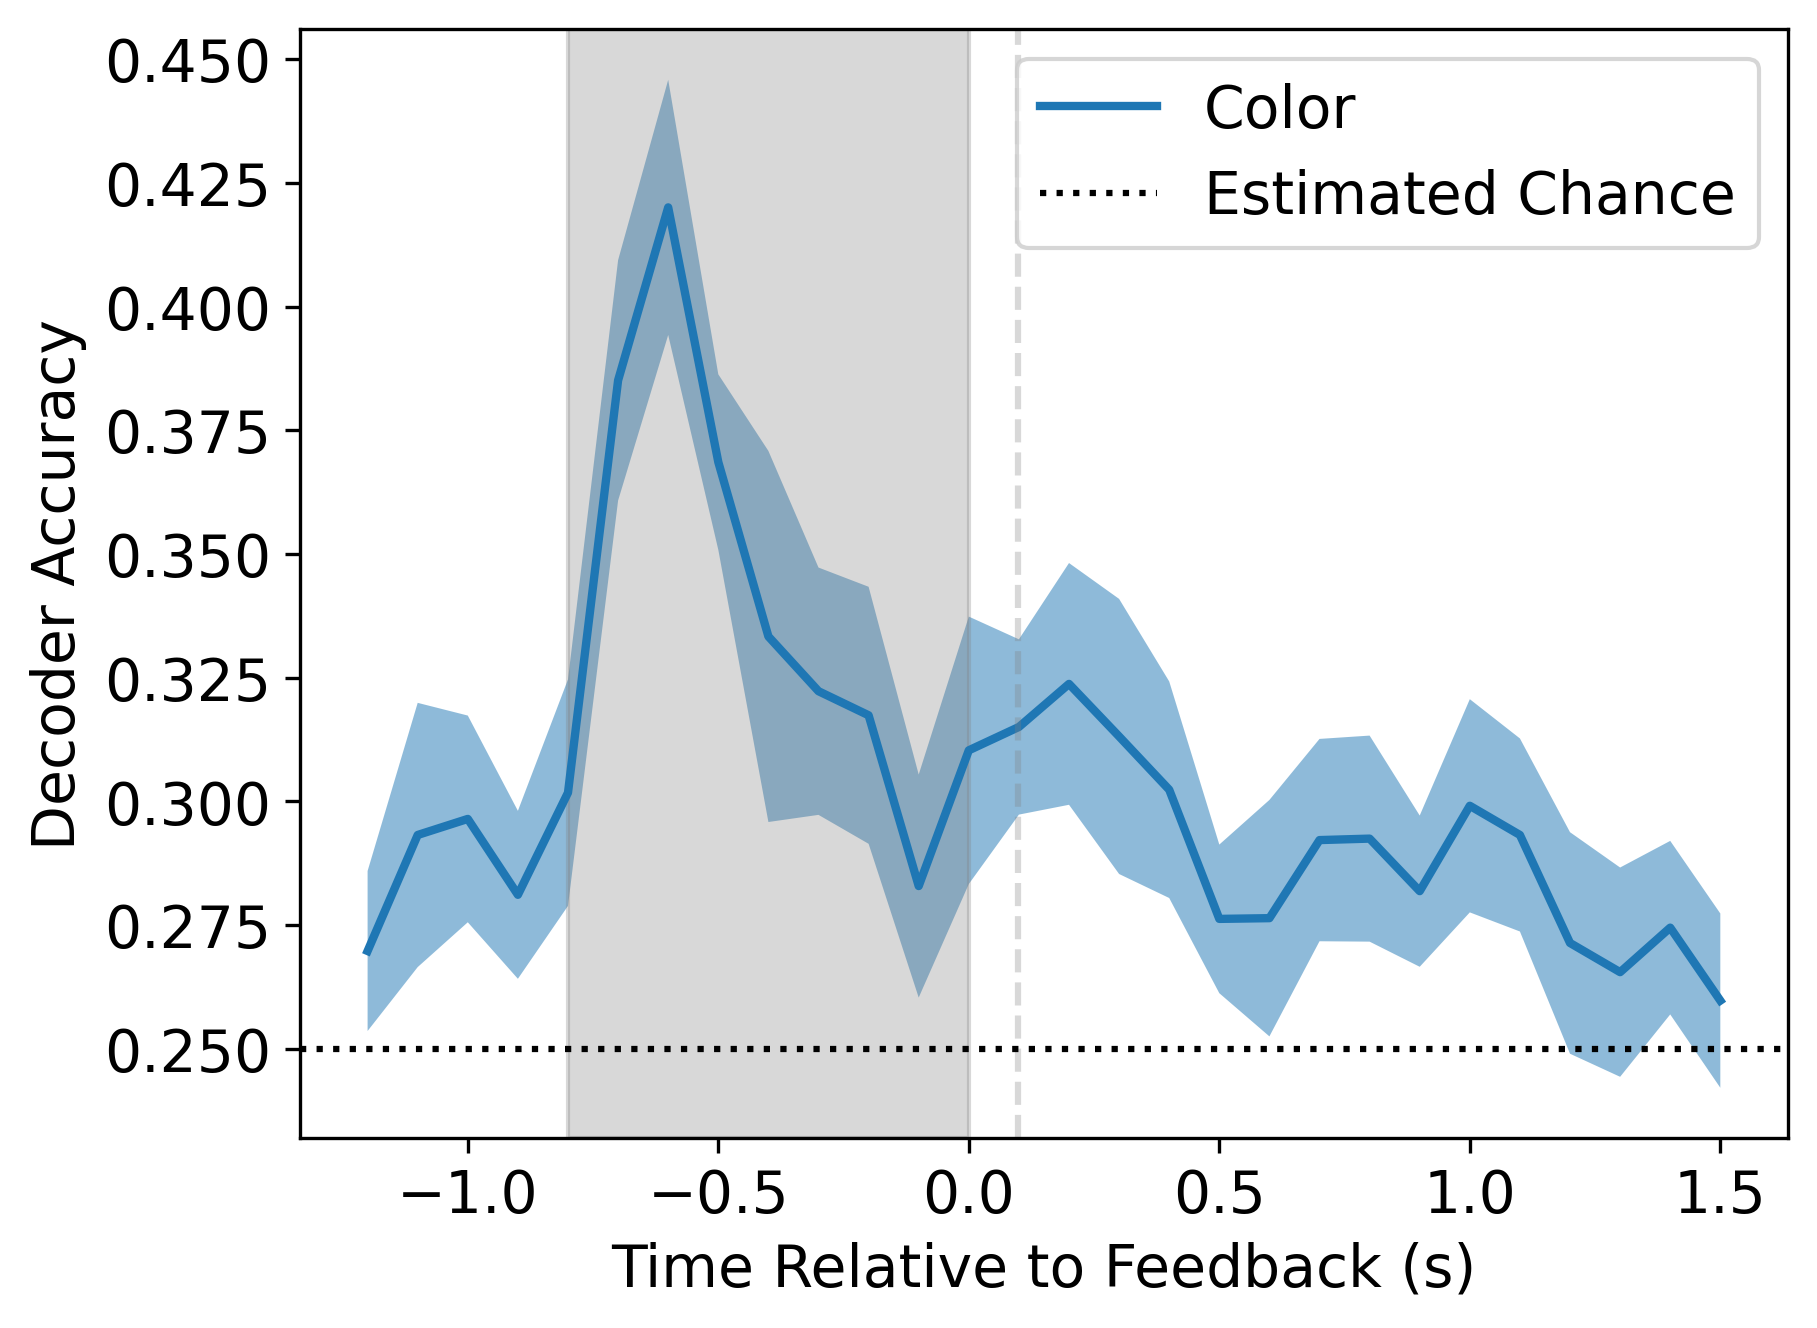

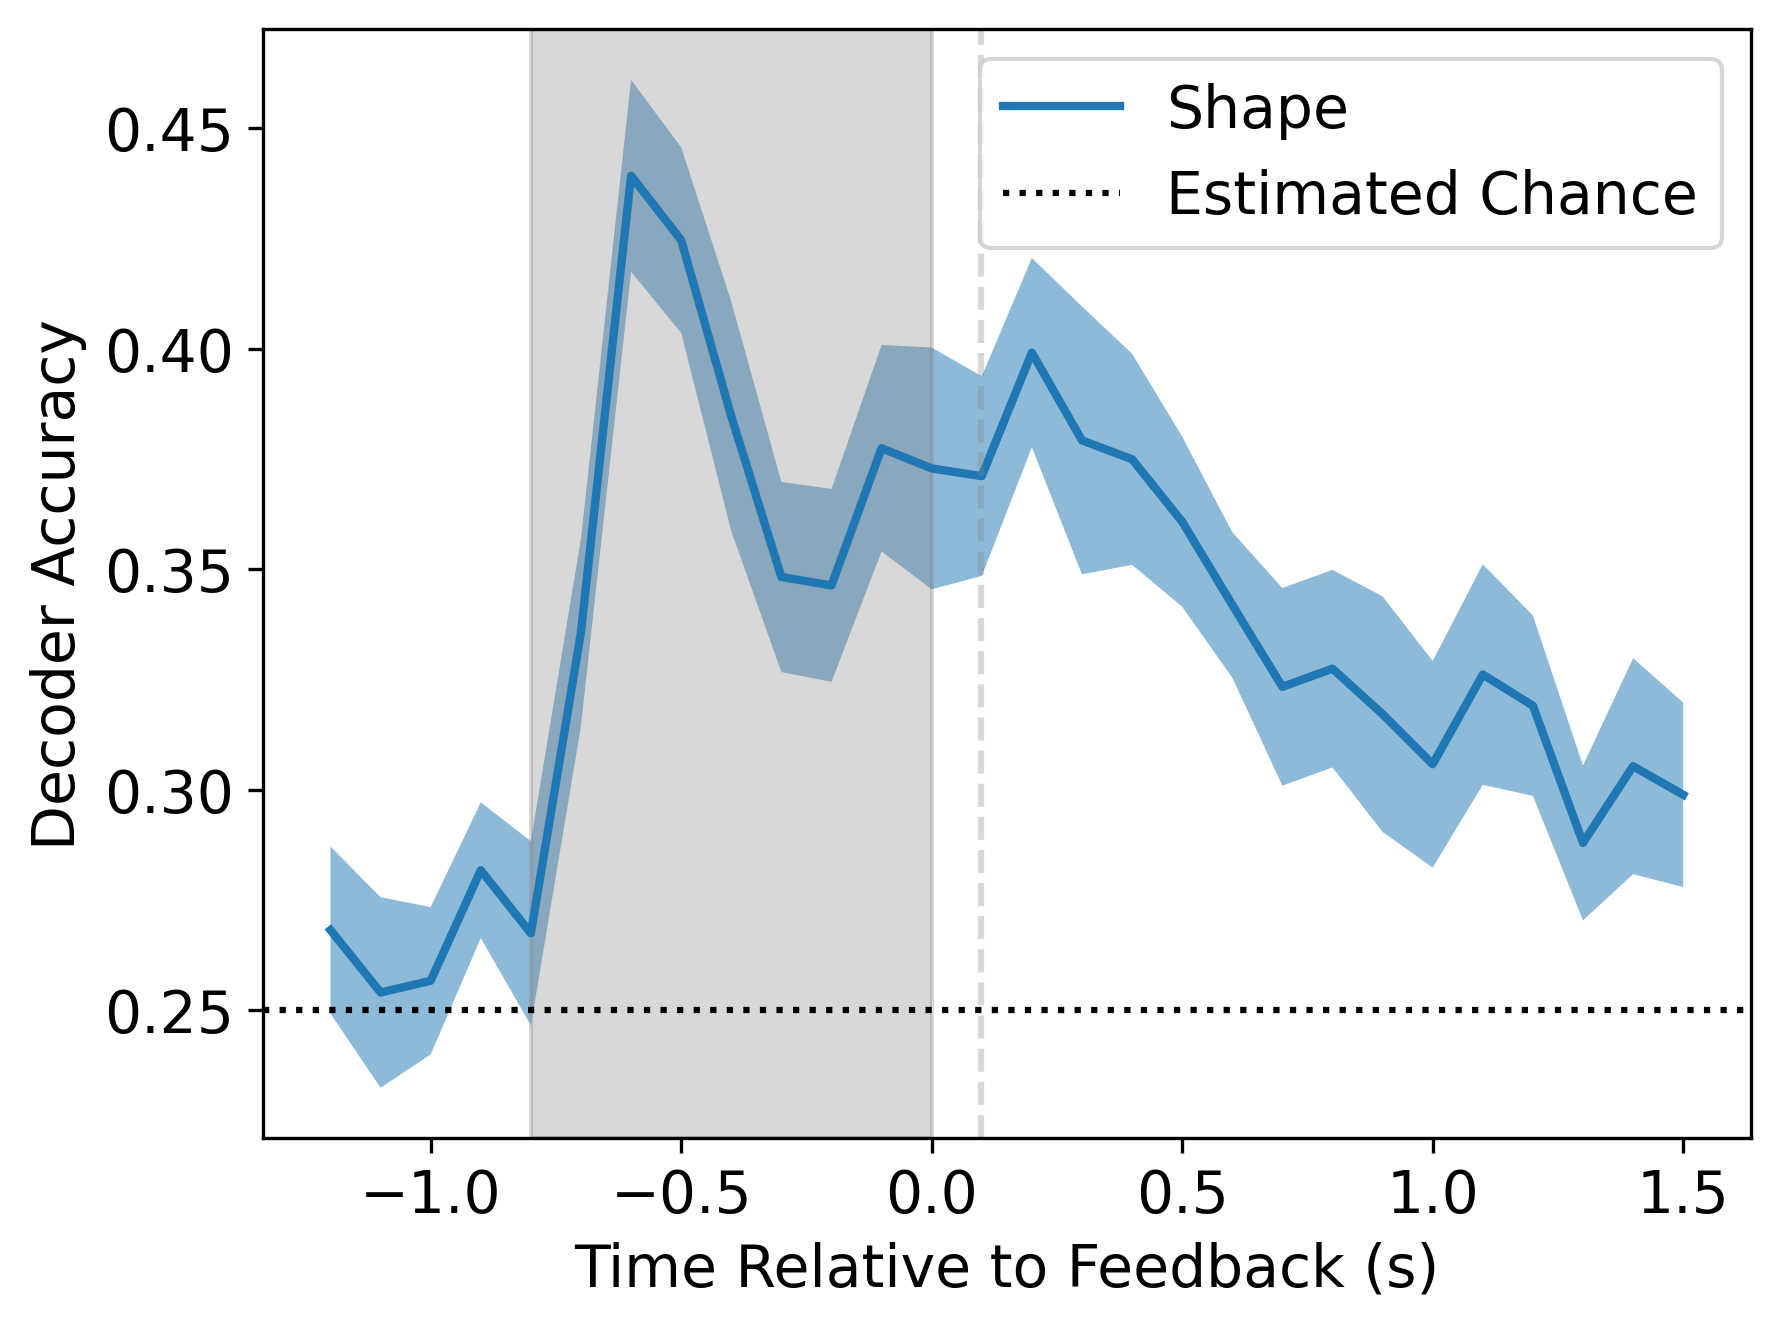

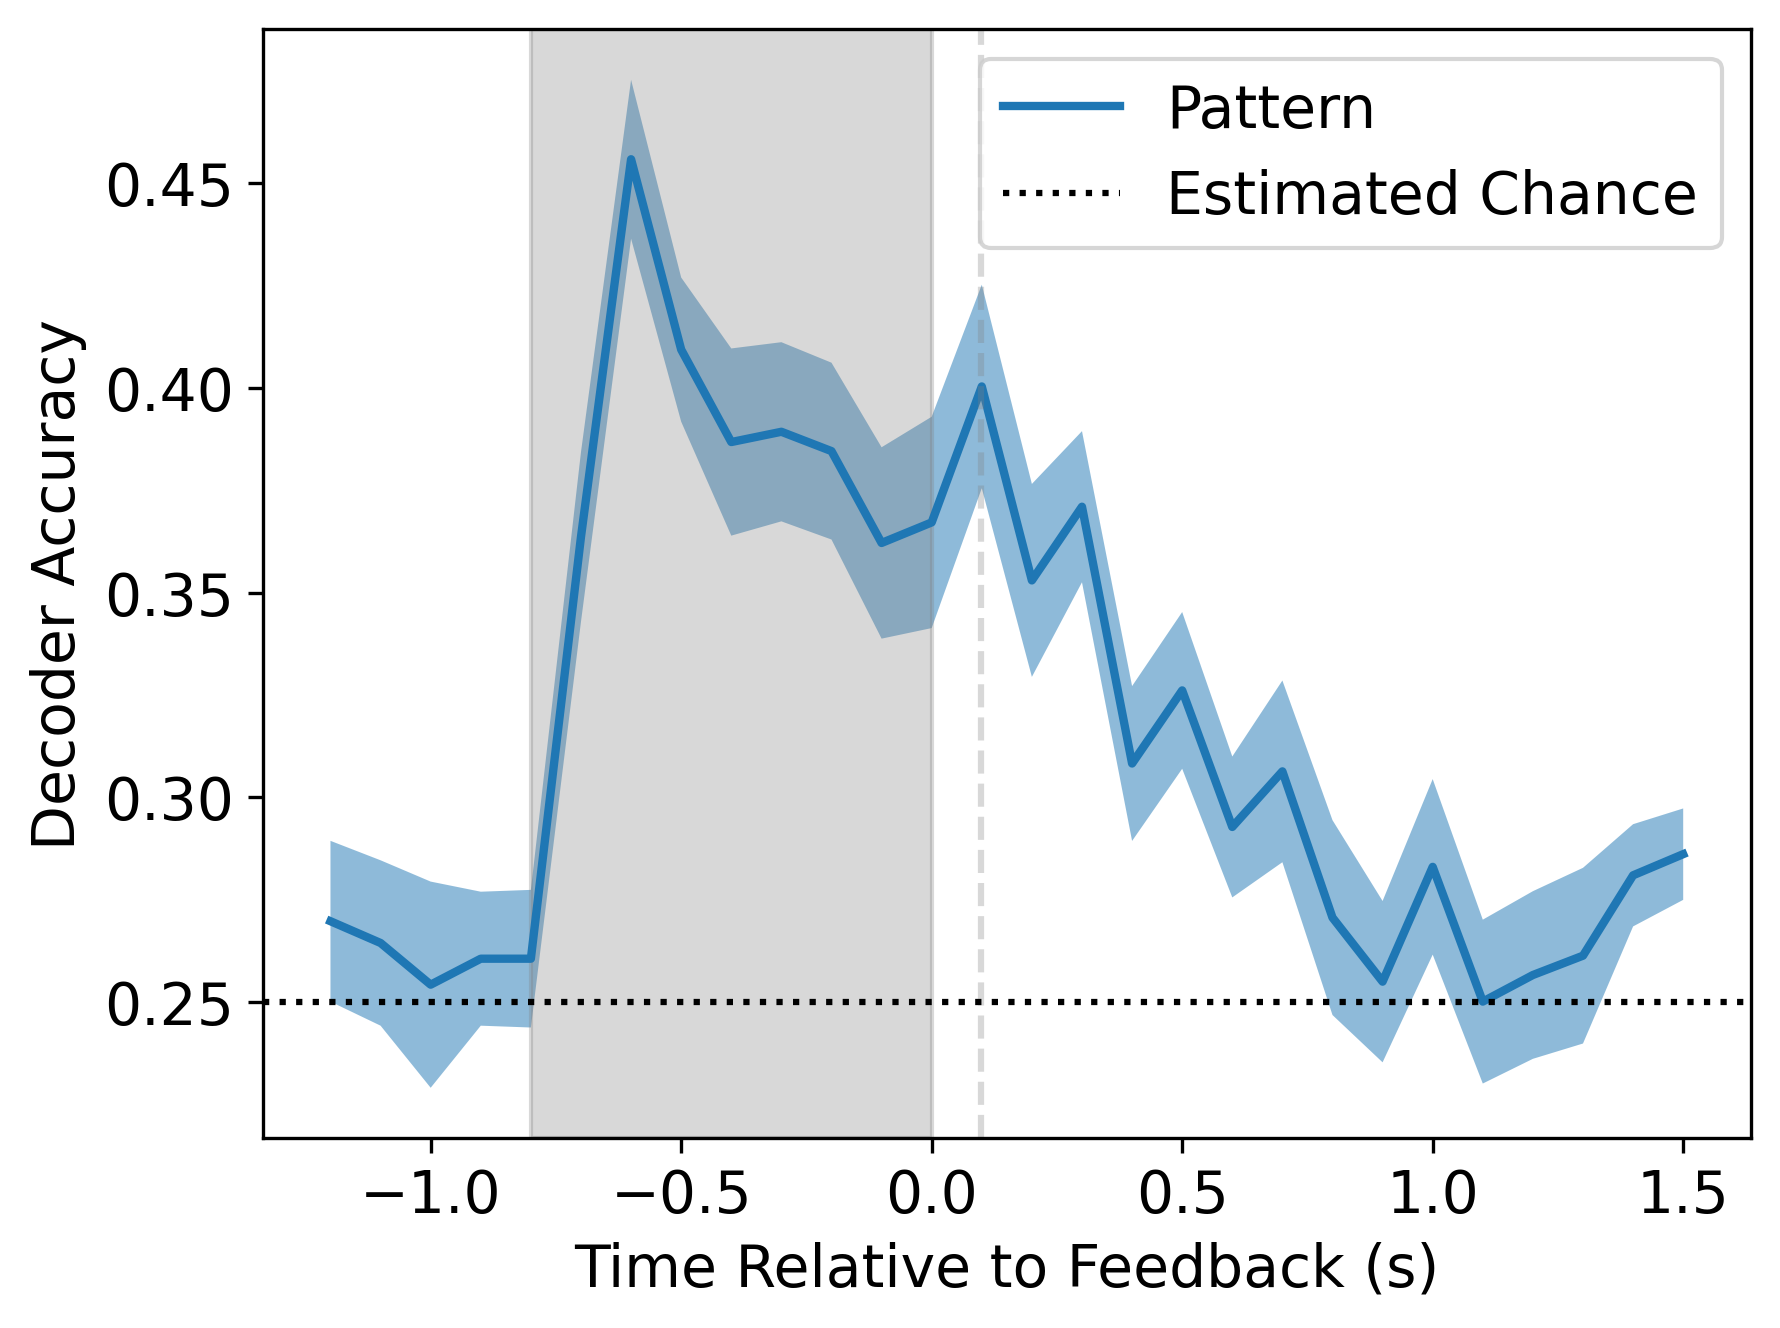

In [12]:
matplotlib.rcParams.update({'font.size': 14})
for i, feature_dim in enumerate(feature_dims):
    fig, ax = plt.subplots()

    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        fs, 
        f"{feature_dim}_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )

    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim}",
        right_align=True, 
        # color='black'
    )

    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})

### Replot Feature Weights

[16.5 29.5 35.5 36.5]
6
[16.5 29.5 35.5 36.5]
6
[16.5 29.5 35.5 36.5]
6


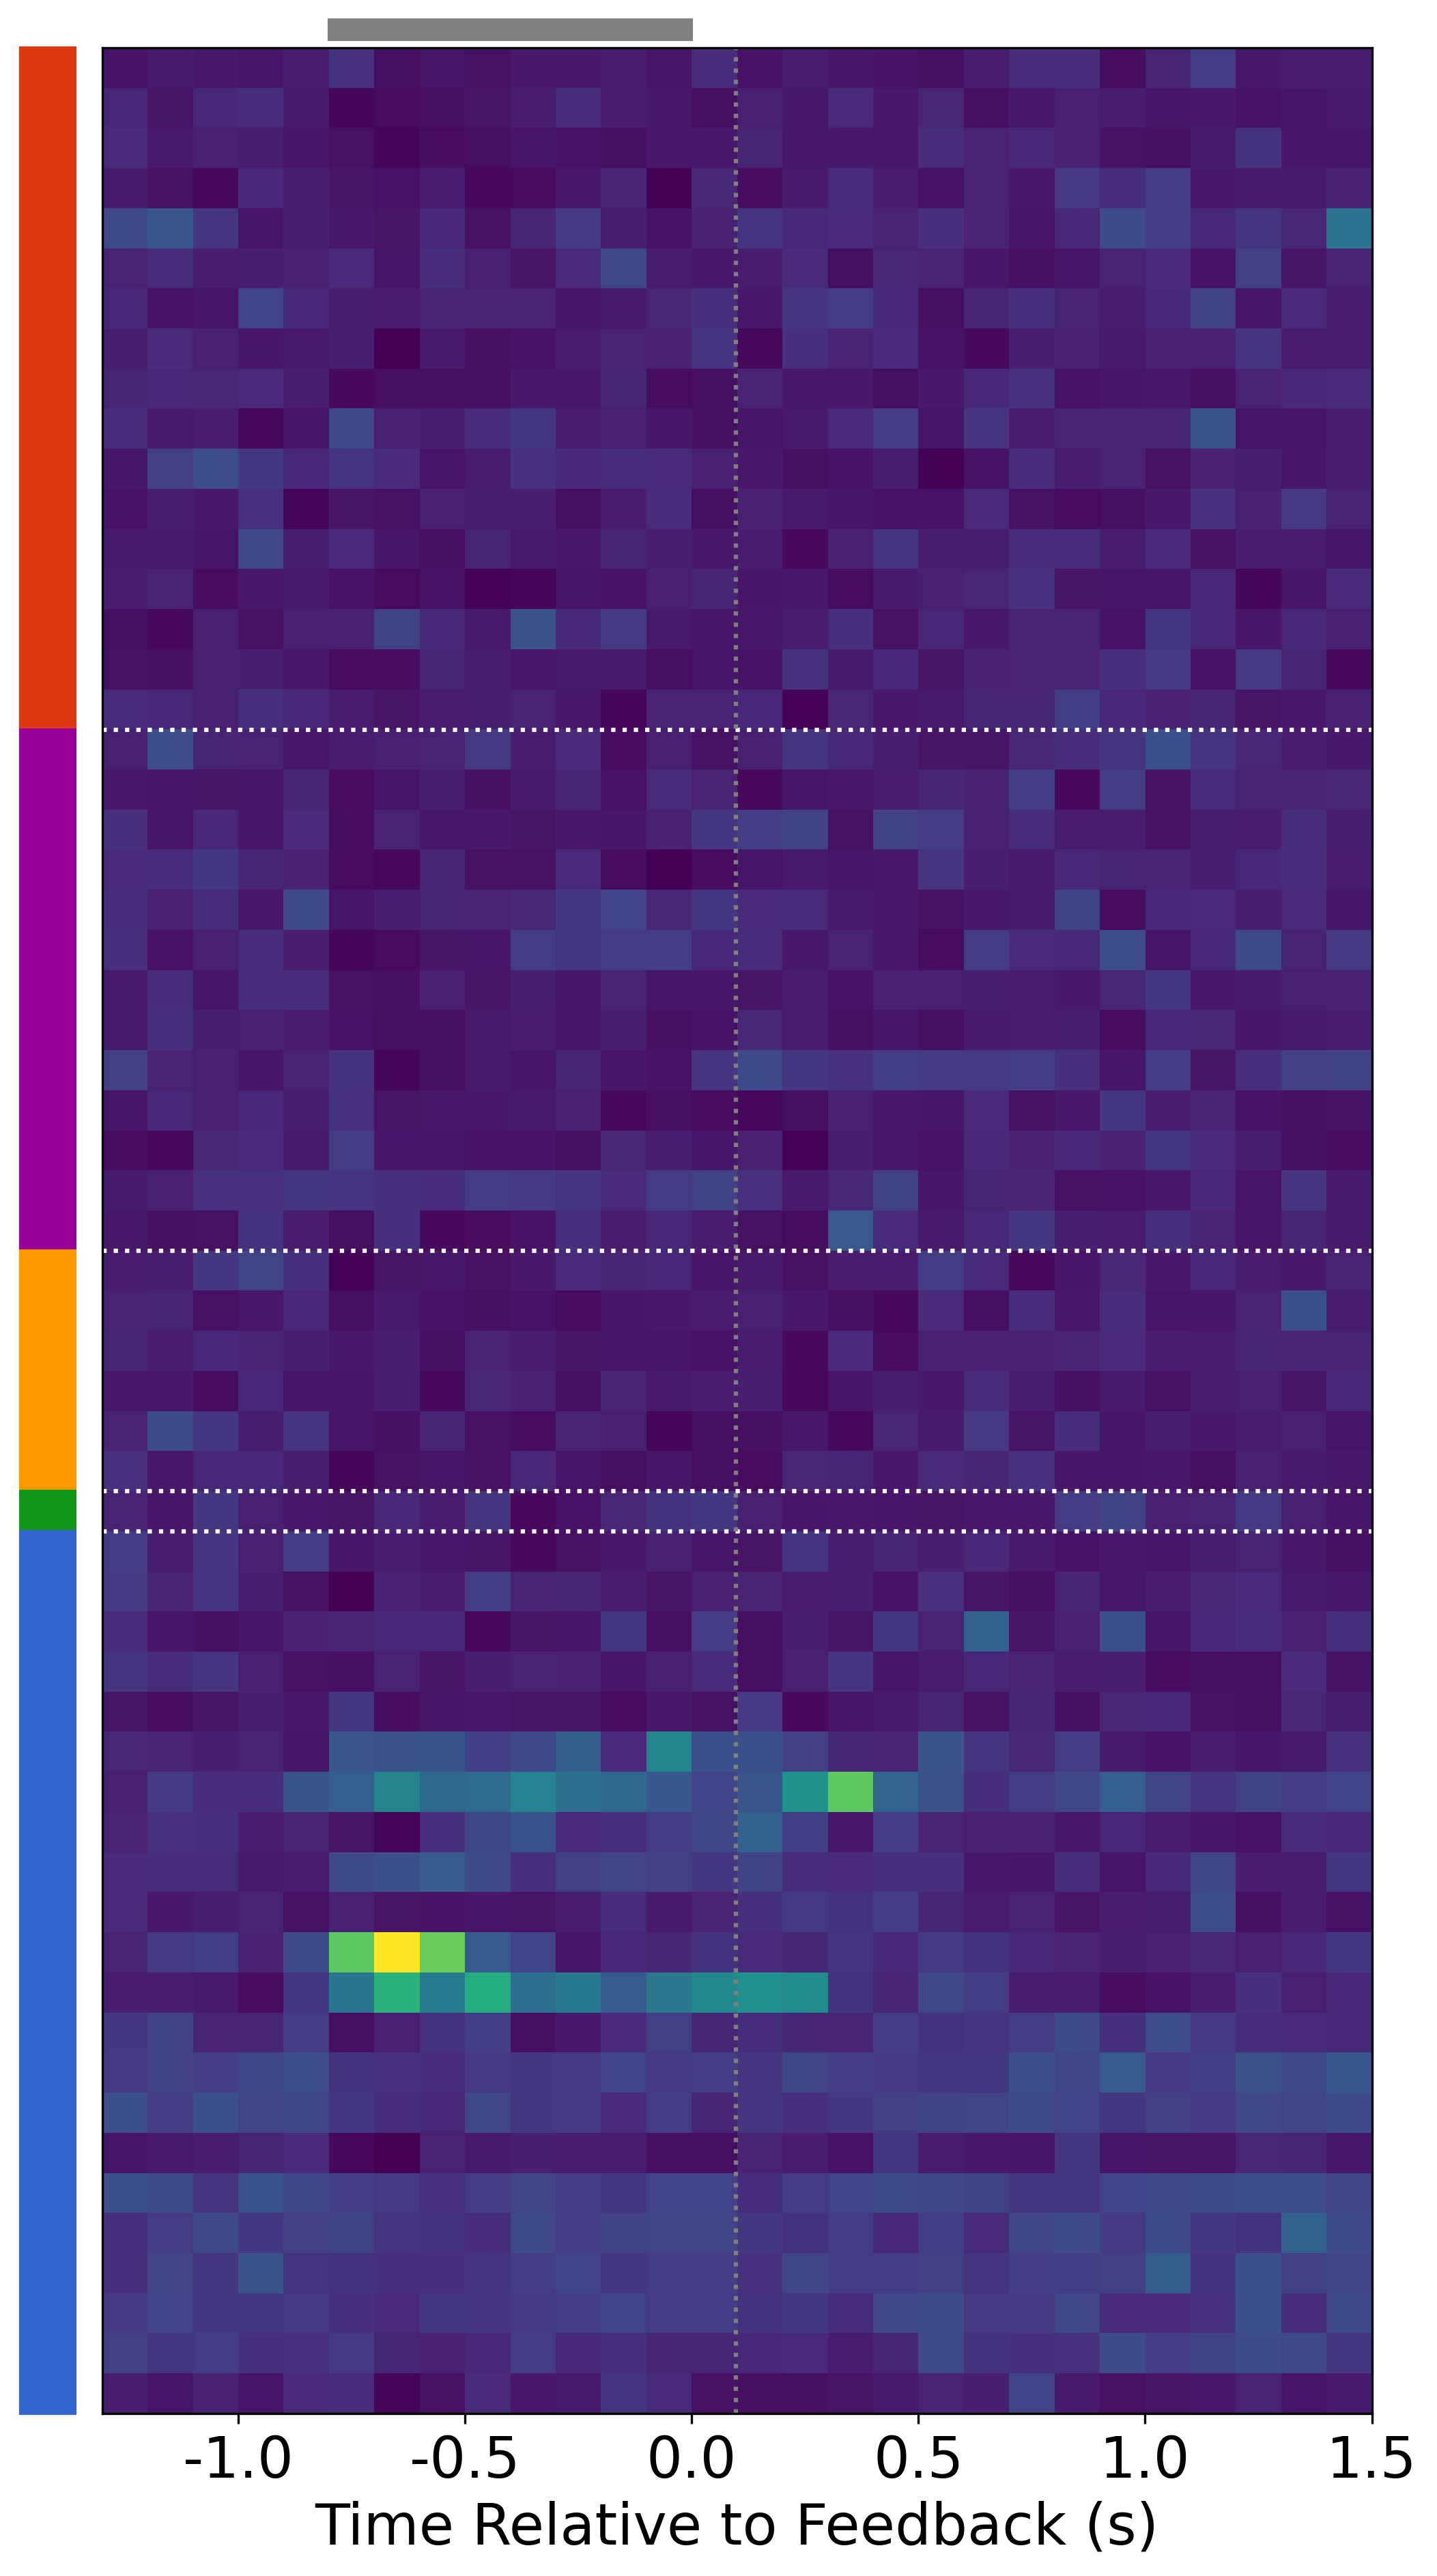

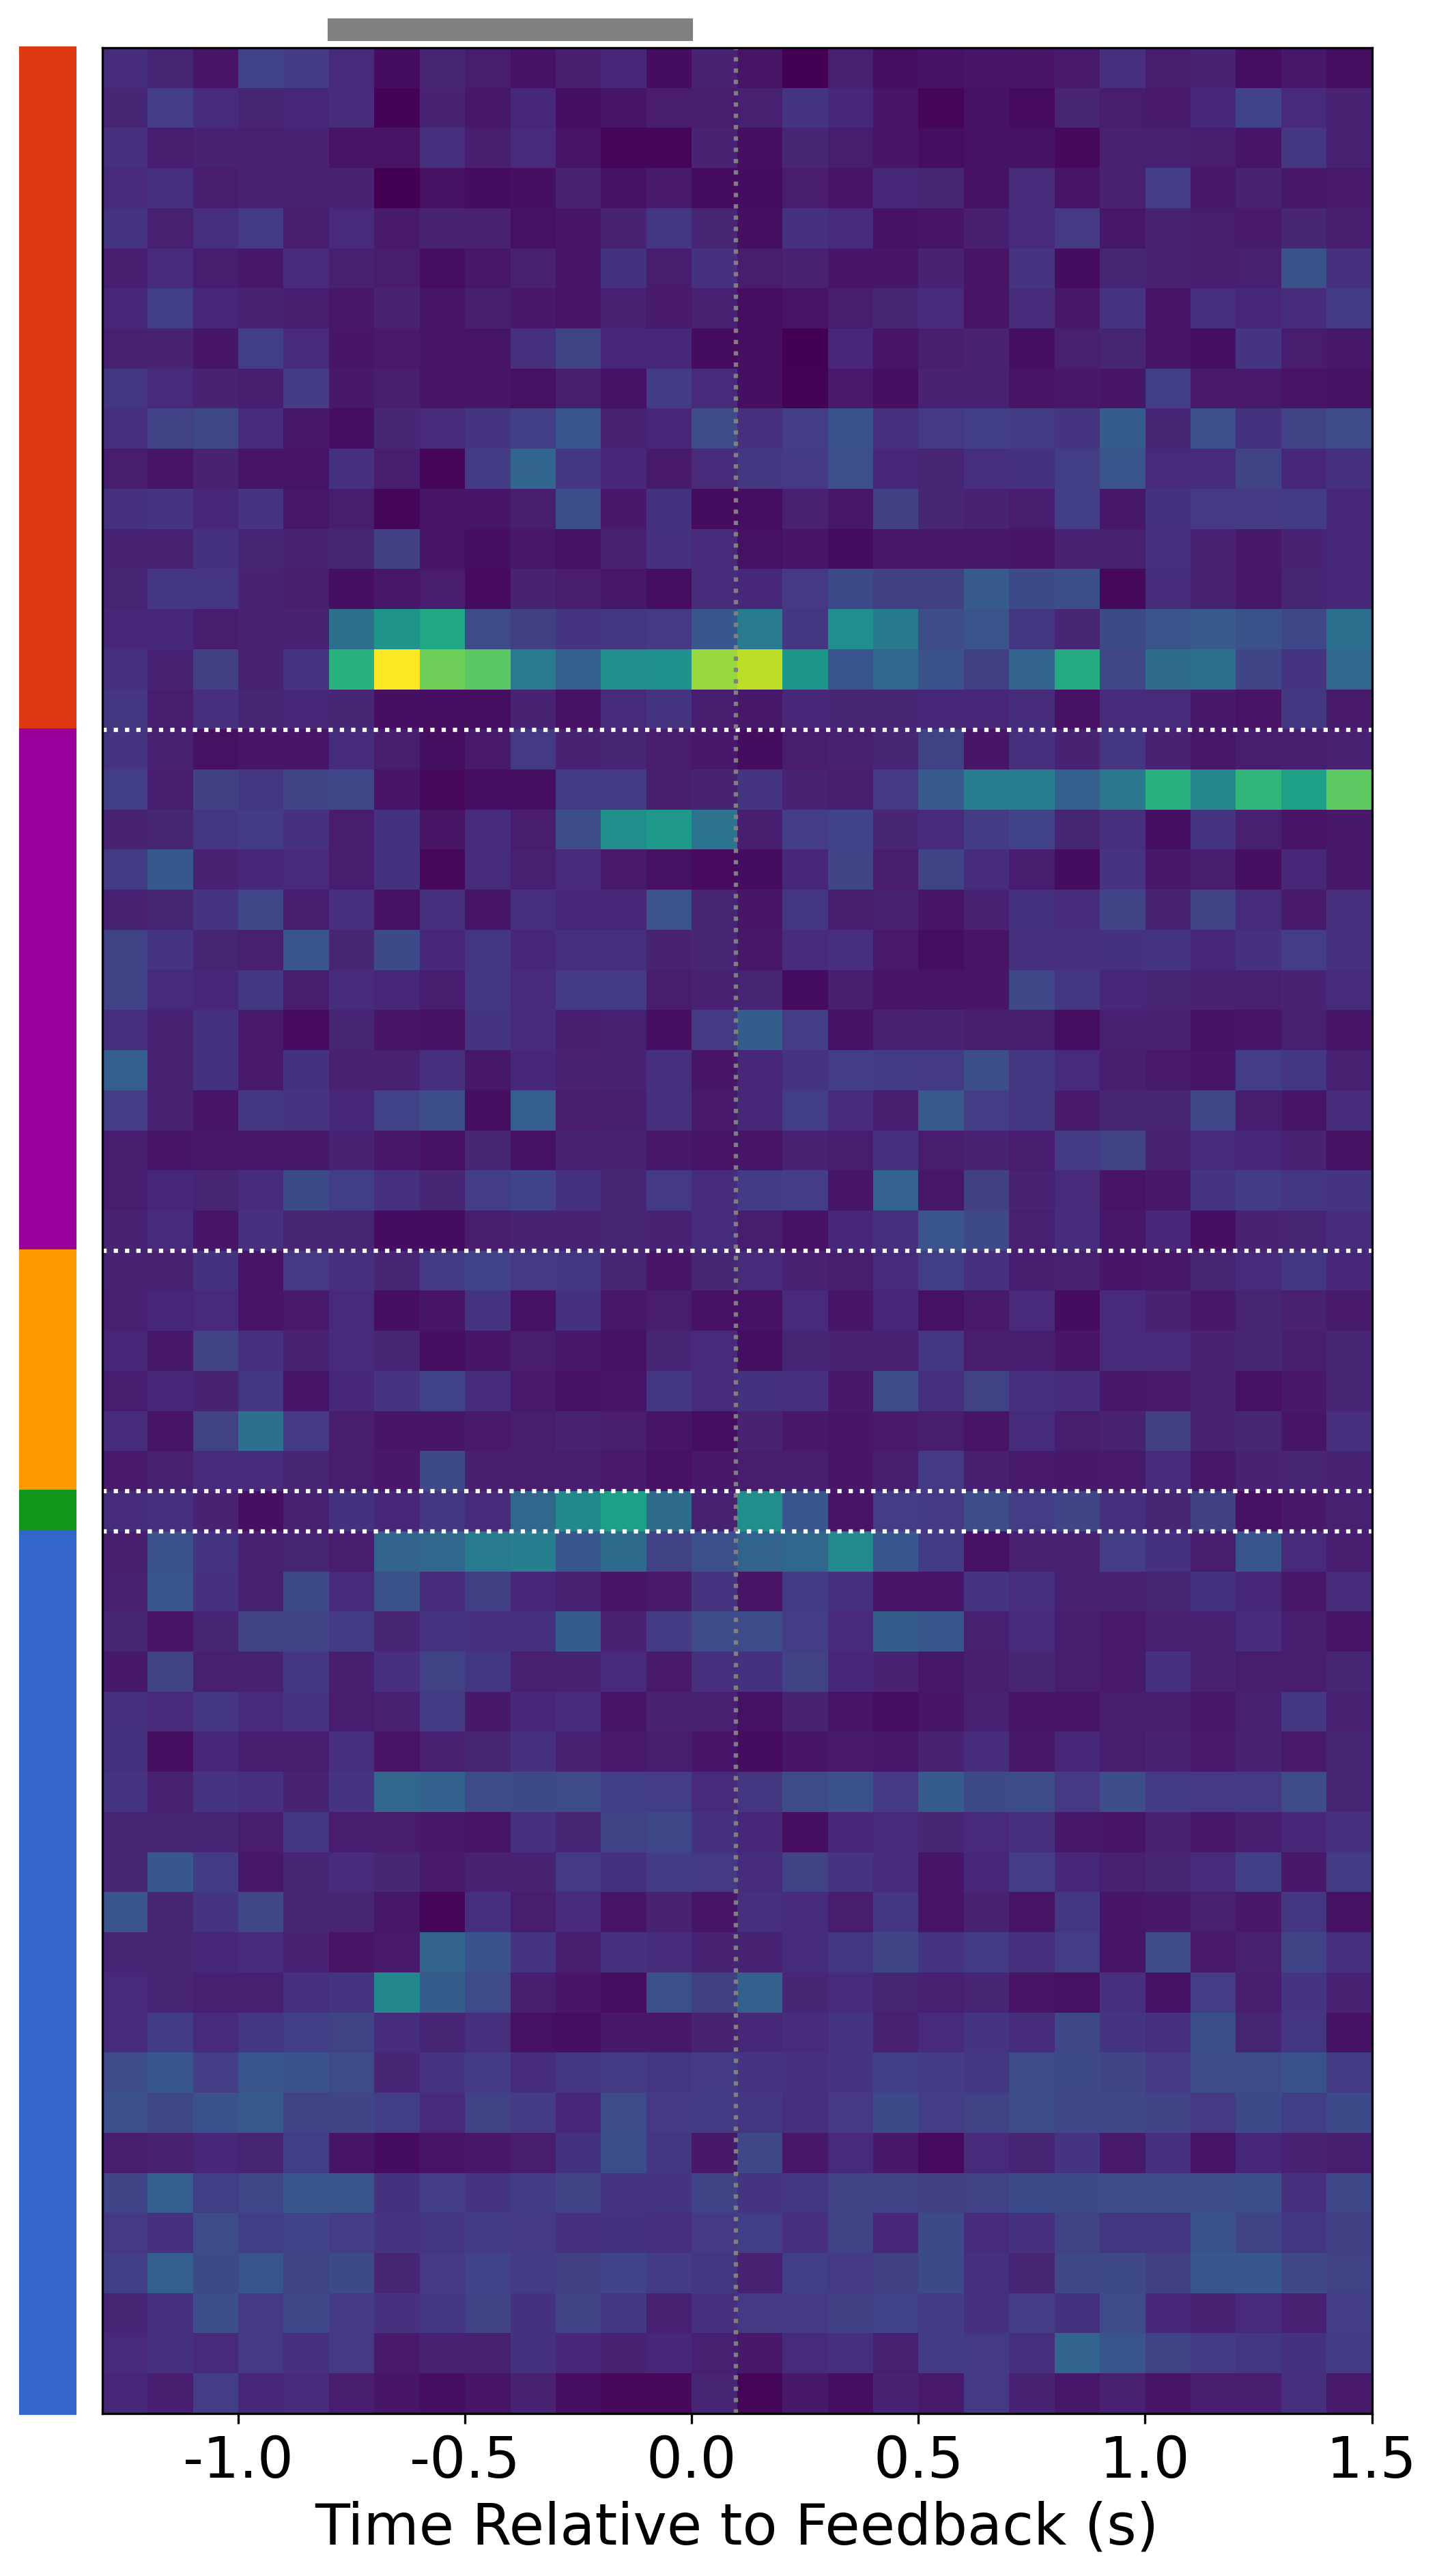

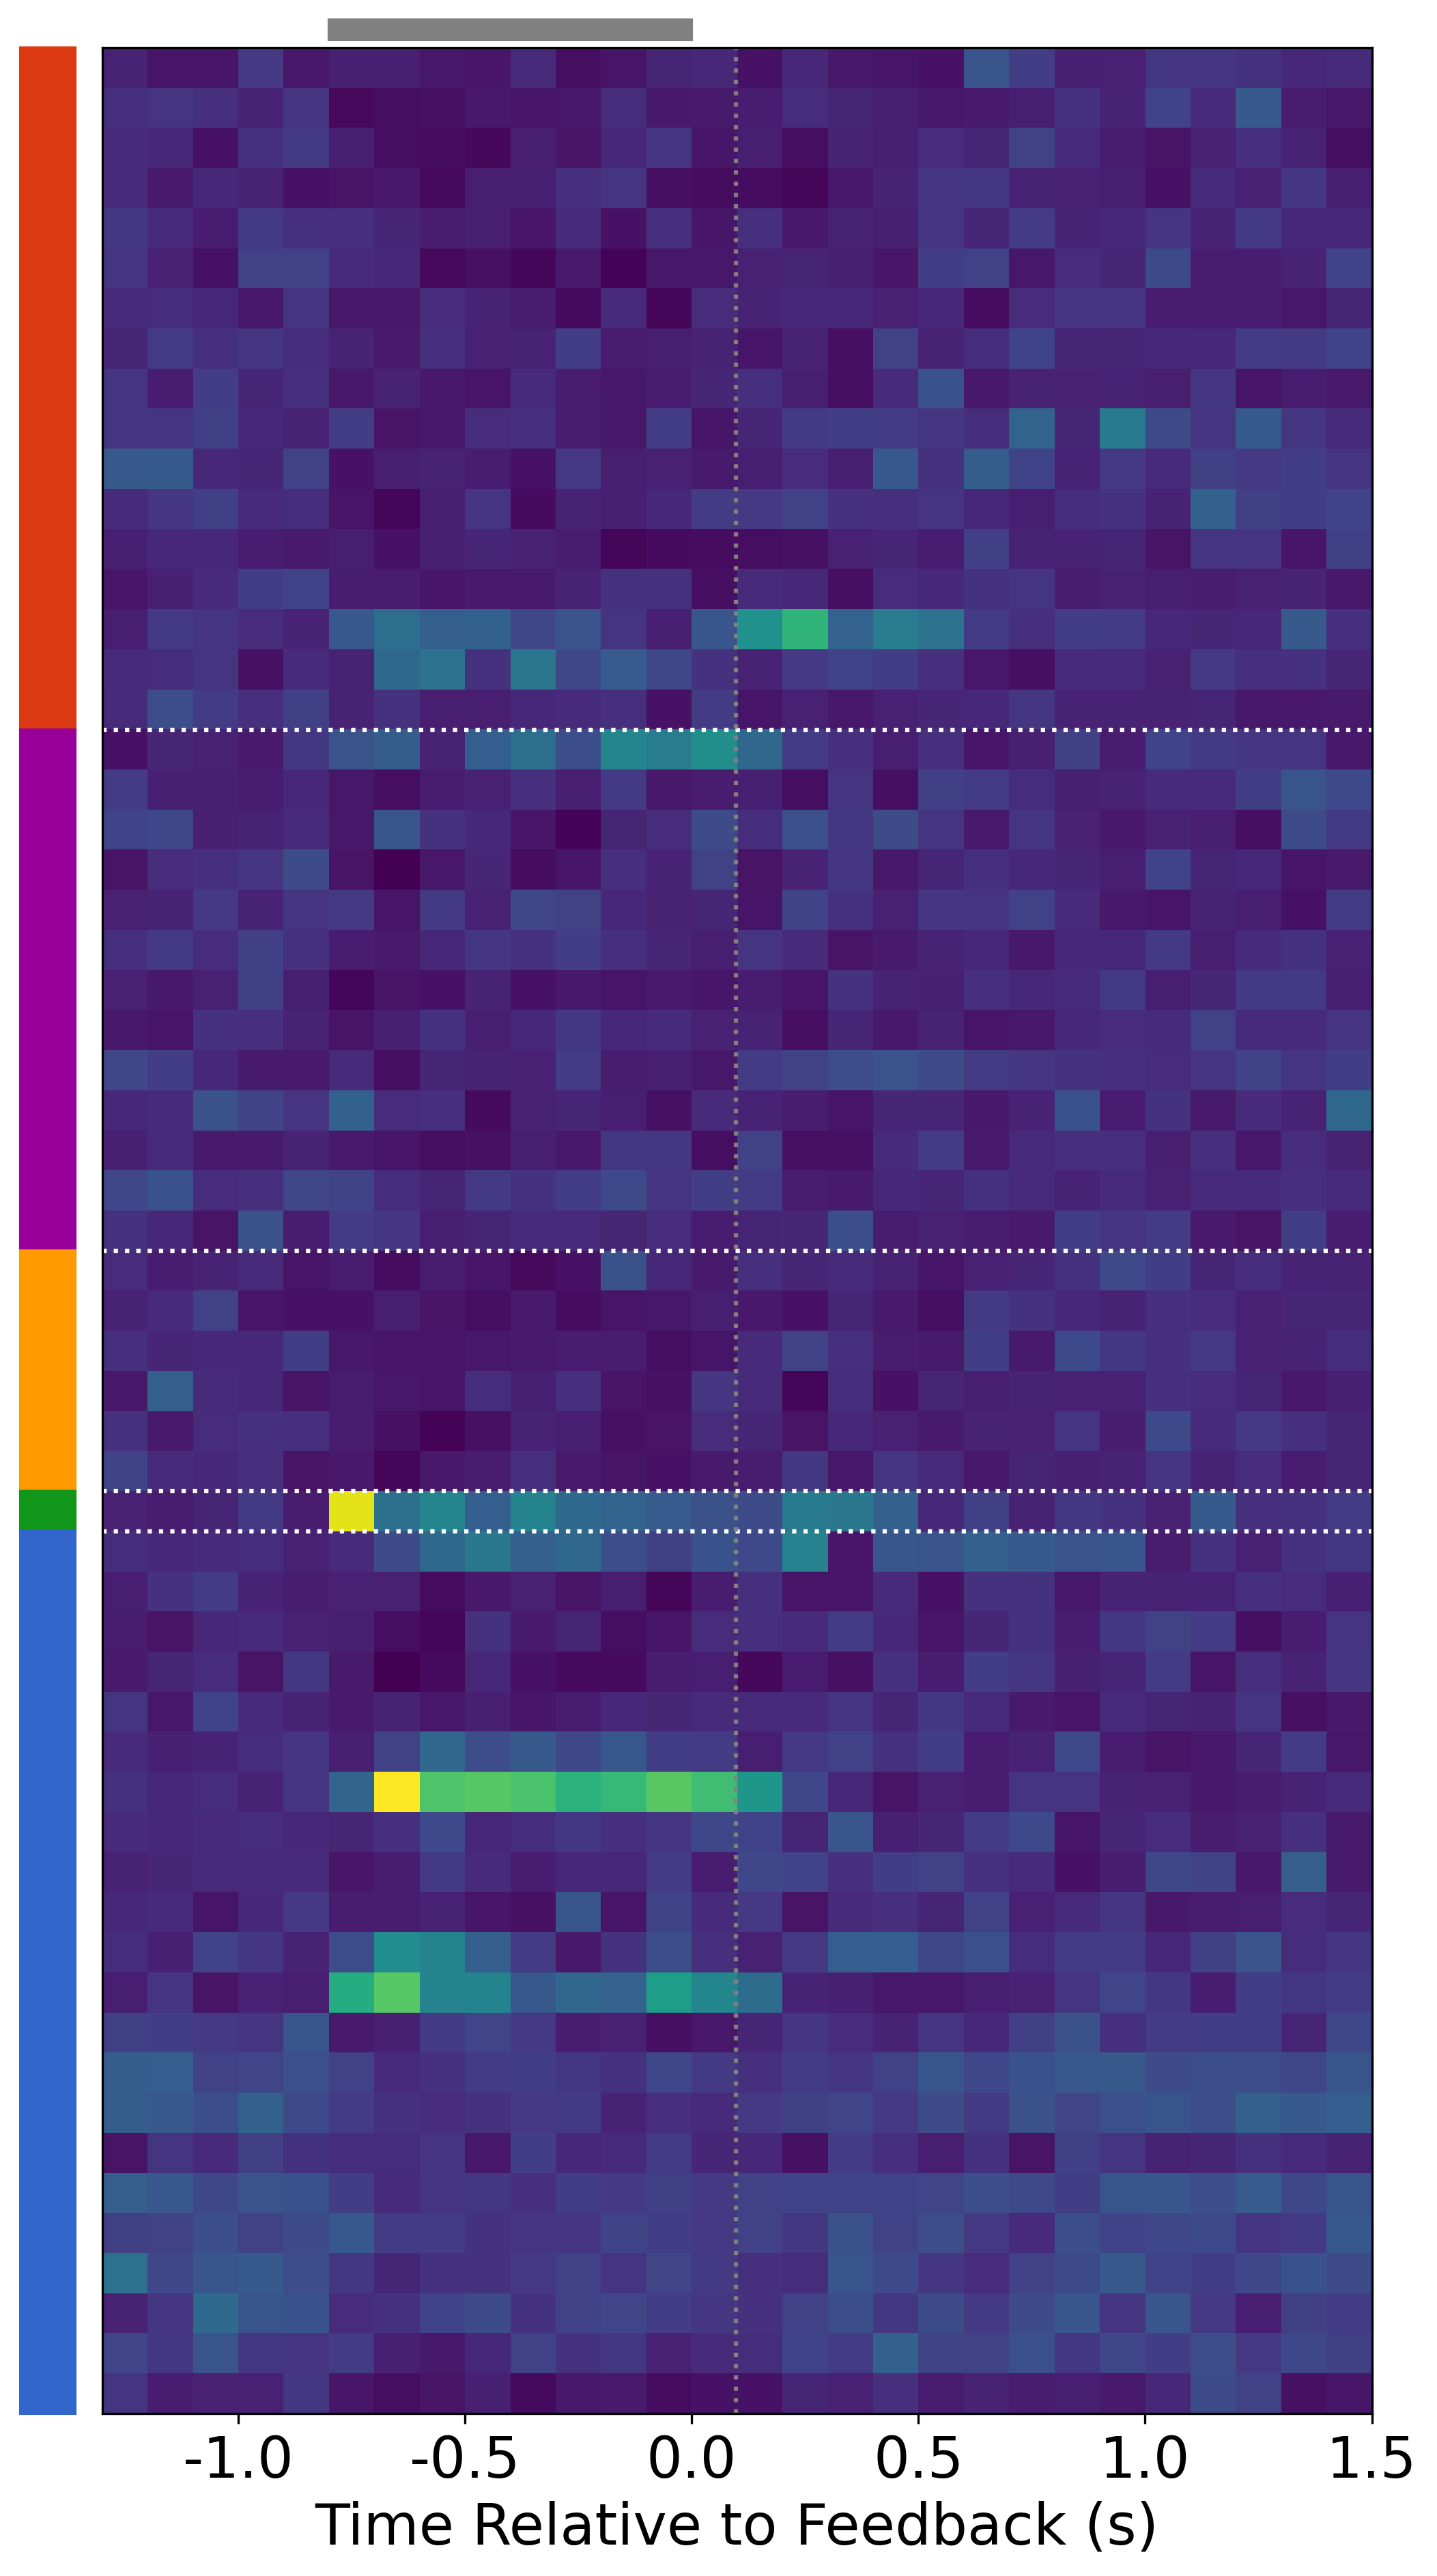

In [16]:
# models are num_time_points x num_models
pre_interval = 1300
post_interval = 1500
matplotlib.rcParams.update({'font.size': 20})

for i, feature_dim in enumerate(feature_dims):
    _, _, _, models, _ = io_utils.load_model_outputs(
        fs, 
        f"{feature_dim}_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 4)

    sums = np.sum(weights, axis=0)

    normalized = weights / sums

    # reorder by temp then ant
    reordered = normalized[reordered_units, :]


    fig, ax = plt.subplots(figsize=(8, 15))
    colors = ax.matshow(reordered, aspect='auto')
    # tick_labels = np.array([-1.2, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1.2])
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * 10 - 0.5
    # fig.colorbar(colors)
    # axis = np.arange(0, 28, 3)s
    # labels = np.around((axis - 13) * 0.1, 1)
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.get_yaxis().set_visible(False)
    ax.set_ylabel([])
    # y_axis = np.arange(0, 59, 5)
    # ax.set_yticks(y_axis)
    # ax.set_yticklabels(y_axis)

    boundaries = np.insert(np.insert(lines, len(lines), reordered.shape[0] - 0.5), 0, -0.5)
    print(lines)
    print(len(boundaries))
    for line in lines:
        ax.axhline(line, color='white', linestyle="dotted")
    colormap = ["#DC3912", "#990099", "#FF9900", "#109618", "#3366CC"]
    for i in range(len(boundaries)-1):
        rect = patches.Rectangle(
            (
                -1.3 - 1,
                (boundaries[i])#+boundaries[i+1]) / 2
            ),
            1.2,
            (boundaries[i+1]-boundaries[i]),
            edgecolor=colormap[i],
            facecolor=colormap[i],
            clip_on=False
        )
        ax.add_patch(rect)
    gray_rect = patches.Rectangle(
        (4.5, -1.2), 8, 0.5,
        edgecolor="gray",
        facecolor="gray",
        clip_on=False,
    )
    ax.add_patch(gray_rect)
    ax.axvline(13.48, color="gray", linestyle="dotted")


### Regen feature plots with different colors, combined

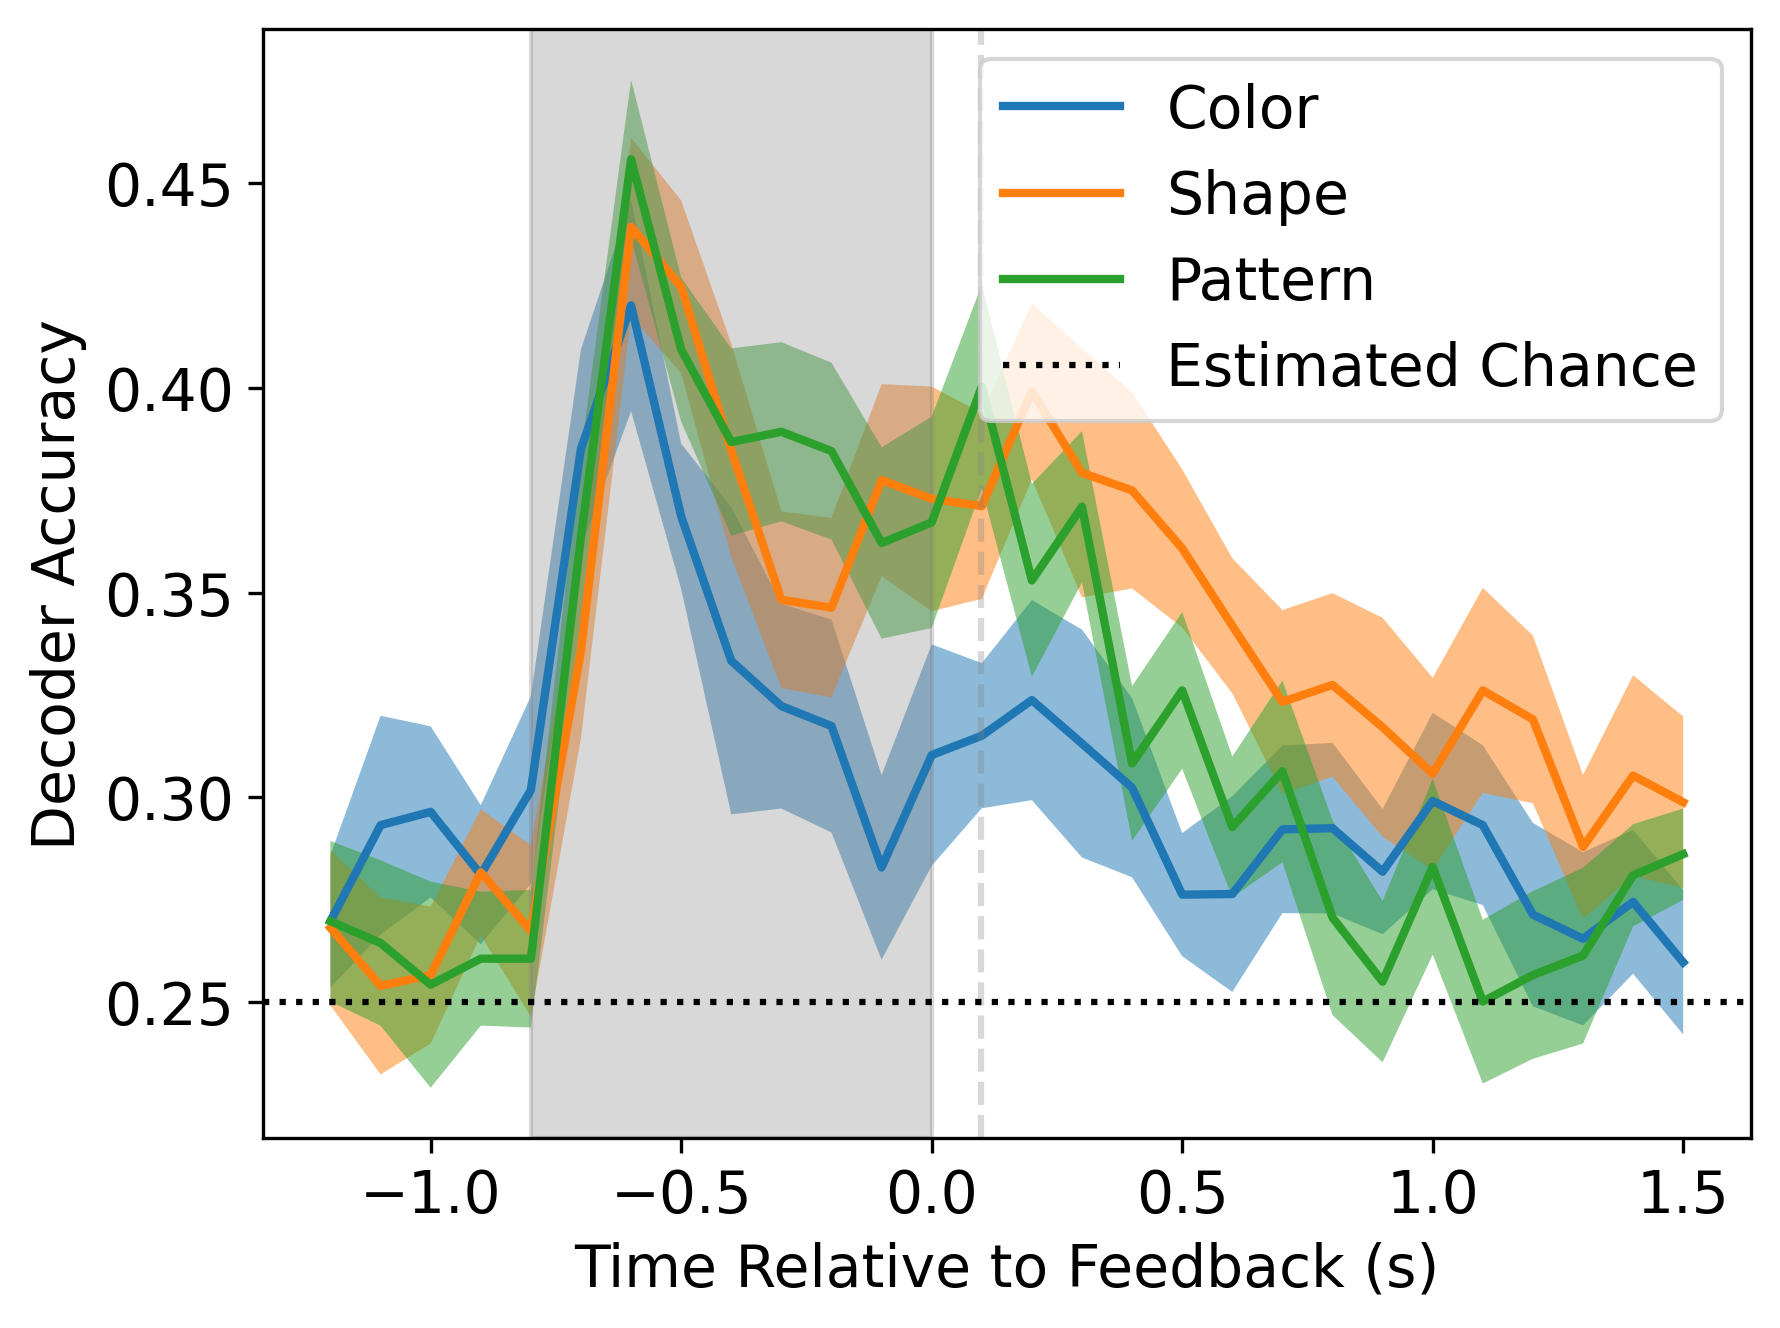

In [5]:
matplotlib.rcParams.update({'font.size': 14})
colors = ["tab:blue", "tab:orange", "tab:green"]
for i, feature_dim in enumerate(feature_dims):
    fig, ax = plt.subplots()
    _, test_accs_by_bin, _, _, _ = io_utils.load_model_outputs(
        fs, 
        f"{feature_dim}_normed_dropout", 
        f"{pre_interval}_fb_{post_interval}",
        "random_split",
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs_by_bin,
        1.3, 1.5, 0.1,
        ax,
        label=f"{feature_dim}",
        right_align=True, 
        color=colors[i]
    )
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")
    ax.legend(prop={'size': 14})